# Introduction

The objective here is to give a short code implementation of GARCH for forecasting and volatility estimation.

The implementation is based on Kevin Sheppard's *arch* package for Python.

We start by importing the necessary packages and uploading a financial data (here using `yfinance` which obtains financial time series from Yahoo Finance).



In [7]:
#In case not yet installed:
#%pip install arch

In [2]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'BEL20 Daily Returns')

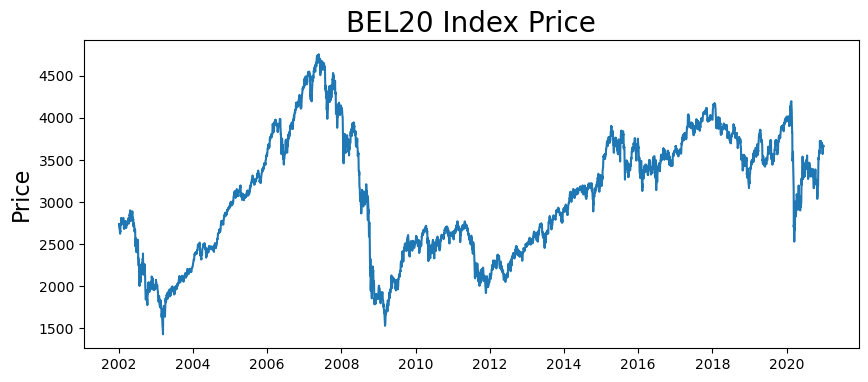

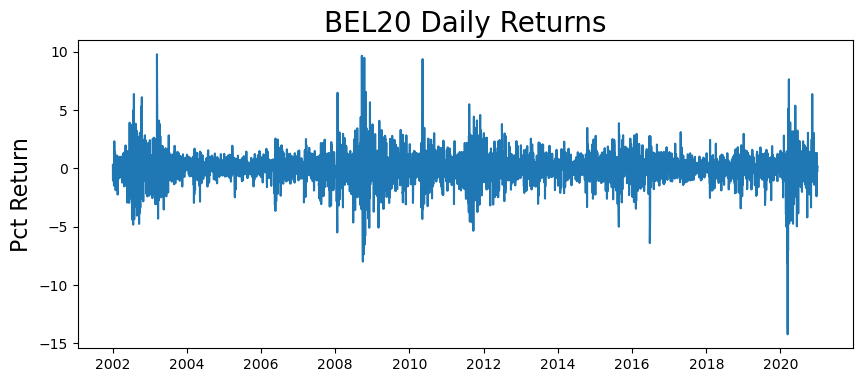

In [48]:
# Download needed data, here Belgium's BEL 20 (^BFX)
# Could be changed for other, like S&P 500 data (ticker ^GSPC)
ticker = "^BFX"
data = yf.download(ticker, start="2002-01-01", end="2021-01-01")

# Calculate daily returns
    # --> Using adjusted price (for dividends, splits...) 
    #no need to account for other changes to estimate return
data['Daily Return'] = 100*data['Adj Close'].pct_change().dropna()
data['Daily Return'] = data['Daily Return'].replace([np.inf, -np.inf], np.nan).dropna()
data=data.iloc[1:-1]

plt.figure(figsize=(10,4))
plt.plot(data['Adj Close'])
plt.ylabel('Price', fontsize=16)
plt.title('BEL20 Index Price', fontsize=20)


returns=data['Daily Return']

plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('BEL20 Daily Returns', fontsize=20)


# PACF

Plotting the partial autocorrelation function (PACF) is a good first step to determine the parameters to be used in the GARCH (p,q) modelling. 

Since the error term follows a similar GARCH process (s.t. $\eta$ is a white noise):

$$\epsilon_t = \eta_t \sqrt{\omega + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2}$$

Then $\epsilon_t^2$ will be similar to an AR process, with its PACF's parameters showing if the 'direct effects' of the $p$ autocorrelations are significant:

$$\epsilon_t = \eta_t^2 (\omega + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2)$$




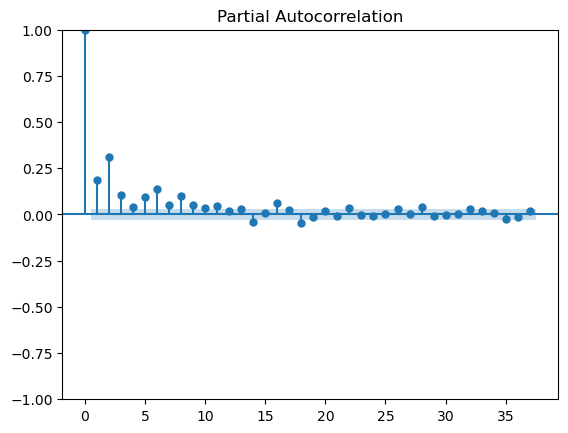

In [50]:
plot_pacf(returns**2)
plt.show()

##After second autocorrelation it experiences faster decay, 
#GARCH(2,2) can be a good first candidate

In [51]:
model = arch_model(returns, p=2, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 95815.30235564295
Iteration:      2,   Func. Count:     21,   Neg. LLF: 27946.543291364876
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1661009518.3369653
Iteration:      4,   Func. Count:     40,   Neg. LLF: 7160.017407202196
Iteration:      5,   Func. Count:     48,   Neg. LLF: 7252.431352953115
Iteration:      6,   Func. Count:     57,   Neg. LLF: 7128.015091515116
Iteration:      7,   Func. Count:     65,   Neg. LLF: 7141.818932261457
Iteration:      8,   Func. Count:     73,   Neg. LLF: 7030.957934604168
Iteration:      9,   Func. Count:     81,   Neg. LLF: 7034.699667872124
Iteration:     10,   Func. Count:     89,   Neg. LLF: 7029.768050827293
Iteration:     11,   Func. Count:     96,   Neg. LLF: 7029.7660791813005
Iteration:     12,   Func. Count:    103,   Neg. LLF: 7029.766002510643
Iteration:     13,   Func. Count:    110,   Neg. LLF: 7029.765998518107
Iteration:     14,   Func. Count:    116,   Neg. LLF: 7029.76

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7029.77
Distribution:                  Normal   AIC:                           14071.5
Method:            Maximum Likelihood   BIC:                           14110.5
                                        No. Observations:                 4855
Date:                Tue, Jun 25 2024   Df Residuals:                     4854
Time:                        04:55:08   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0674  1.276e-02      5.281  1.288e-07 [4.236e-02,9.237e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0315  9.937e-03      3.167  1.541e-03 [1.199e-02,5.095e-02]
alpha[1]       0.1169  2.023e-02      5.777  7.619e-09   [7.722e-02,  0.157]
alpha[2]       0.0562  3.550e-02      1.584      0.113  [-1.335e-02,  0.126]
beta[1]        0.3234      0.217      1.492      0.136     [ -0.101,  0.748]
beta[2]        0.4865      0.188      2.593  9.507e-03     [  0.119,  0.854]
============================================================================

Covariance estimator: robust
"""

* Since all parameters but alpha 2 are significant, let's try GARCH(1,2)

In [53]:
model = arch_model(returns, p=1, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17510739187.462692
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2731415391.272805
Iteration:      3,   Func. Count:     22,   Neg. LLF: 9856.505530839017
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7094.4204742387155
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7039.635872582196
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7112.832954805979
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7031.143967903969
Iteration:      8,   Func. Count:     53,   Neg. LLF: 7036.959813921672
Iteration:      9,   Func. Count:     59,   Neg. LLF: 7029.832834166013
Iteration:     10,   Func. Count:     64,   Neg. LLF: 7029.832774071179
Iteration:     11,   Func. Count:     68,   Neg. LLF: 7029.832774071479
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7029.832774071179
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7029.83
Distribution:                  Normal   AIC:                           14067.7
Method:            Maximum Likelihood   BIC:                           14093.6
                                        No. Observations:                 4855
Date:                Tue, Jun 25 2024   Df Residuals:                     4854
Time:                        04:55:26   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0673  1.277e-02      5.275  1.327e-07 [4.232e-02,9.236e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0205  5.315e-03      3.858  1.142e-04 [1.009e-02,3.092e-02]
alpha[1]       0.1123  1.512e-02      7.430  1.082e-13   [8.269e-02,  0.142]
beta[1]        0.8766  1.581e-02     55.441      0.000     [  0.846,  0.908]
============================================================================

Covariance estimator: robust
"""

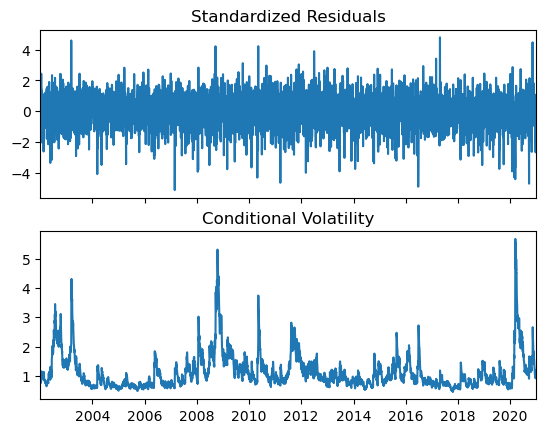

In [54]:
res = model.fit(update_freq=0, disp="off")
fig = res.plot()

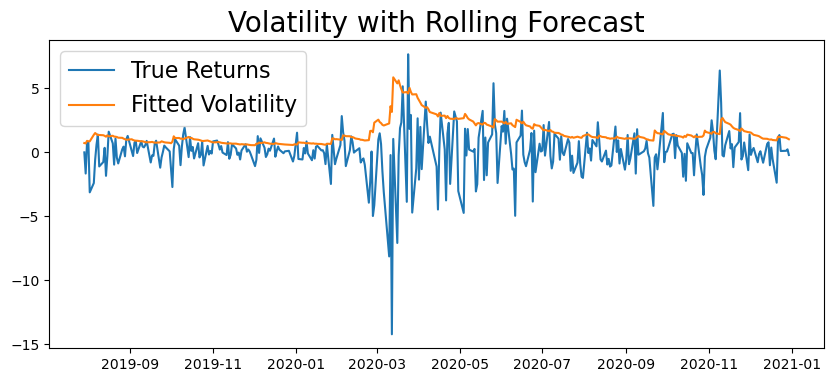

In [56]:
# Initialize an empty list to store rolling predictions
rolling_predictions = []

# Define the size of the test set (number of observations to forecast)
test_size = 365

# Rolling forecast process
for i in range(test_size):
    # Slice the training set to include all data up to the current point in the rolling window
    train = returns[:-(test_size-i)]
    
    # Initialize the GARCH(1,2) model on the training data
    model = arch_model(train, p=1, q=2)
    
    # Fit the model to the training data
    model_fit = model.fit(disp='off')
    
    # Forecast the next observation (horizon=1 means the next time step)
    pred = model_fit.forecast(horizon=1)
    
    # Append the predicted volatility (standard deviation) for the next time step to the list
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

# Convert the rolling predictions list to a pandas Series, aligning it with the index of the test set
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])

# Plotting the results
plt.figure(figsize=(10,4))

# Plot the true returns for the test set period
true, = plt.plot(returns[-test_size:])

# Plot the rolling predictions of volatility
preds, = plt.plot(rolling_predictions)
plt.title('Volatility with Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Fitted Volatility'], fontsize=16)

# Show the plot
plt.show()